%%latex \tableofcontents

In [487]:
# Basic imports
import os
master_dir = os.getcwd()
data_dir = os.path.join(master_dir, "Data")
import csv
import time
from itertools import product
import warnings
import numpy as np
import pandas as pd
import scipy.io
import pickle
from typing import Callable, Any
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (10, 5)
# Scikit learn neural network
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error, make_scorer
# PyTorch
import torch.optim
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Preamble - define functions

In [452]:
def f(x):
    """
    The function of interest, here sin(x^2)
    """
    return np.sin(x**2)

In [453]:
SIN_EXERCISE_END_INTERVAL = 3*np.pi

In [454]:
def generate_sine_data(step: float = 0.05, noise: bool = False, std: float = 0.2):
    """
    Generates training/test data for the second exercise where we try to approximate y=sin(x**2).

    :param step: The step size i.e. spacing between the different points.
    :param noise: Boolean indicating whether we train on noisy data.
    :param std: Standard deviation of the noisy data.
    :return: Tuple containing x values and corresponding function values.
    """
    # Generate x values
    X = np.arange(0, SIN_EXERCISE_END_INTERVAL, step=step)
    # Generate y values
    y = f(X)
    # Add noise if so desired
    if noise:
        y += np.random.normal(loc=0, scale=std, size=y.shape)
        
    # Reshape into correct shape
    X = np.reshape(X, (X.shape[0],1))
    # y = np.reshape(y, (y.shape[0],1))

    return X, y

To write to CSV files:

In [455]:
def write_to_csv(filename, values) -> None:
    """Writes values to a CSV file, automatically gets located in the Data folder of this assignment.

    Args:
        filename (str): The file name of the CSV file to which values is going to be saved.
        values (list): The values to be saved to the CSV file.
    """
    with open(os.path.join(data_dir, filename), 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(values)

In [499]:
class FeedForwardNet(MLPRegressor):
    """
    Simple subclass of scikit-learn's MLP Regressor, to set some of the properties to other default values and to easily
    change the hyperparameters (hidden layers, solver, max number of iterations etc).
    """
    
    def __init__(self, **params):  # , hidden_layer_sizes: Any = (10,), solver: str = "sgd", max_iter: int = 1000, n_iter_no_change: int = 25, **params
        """
        Initialize the network
        :param: hidden_layer_sizes: tuple: Tuple containing the sizes of the hidden layers:
        :param: solver: str: Identifier for the solver we are going to use
        :param: max_iter: int: Maximum amount of training epochs (we use early stopping).
        :param: patience: int: Amount of training epochs to wait before terminating due to early stopping.
        """
        
        # Initialize the superclass (we will override later on)
        super().__init__(**params)

        # # Define scikit learn's MLP regressor with specified properties
        # self.hidden_layer_sizes = hidden_layer_sizes
        # # ^ amount of hidden layers and their sizes
        # self.solver = solver 
        # # ^ which optimization algorithm to use
        # self.activation = 'relu'
        # # ^ which activation function to use
        # self.max_iter = max_iter 
        # # ^ max number of iterations for training
        # self.n_iter_no_change = n_iter_no_change
        # # ^ amount of training epochs we wait before stopping training in the early stopping
        # self.verbose = False
        # # ^ to print training progress
        # self.learning_rate = "constant"
        
        # Additional variables to simplify plotting procedures later on
        self.loss_curve_valid_ = []
        # ^ list containing the losses on the validation set
        self.best_iteration = 0
        # ^ iteration at which we observed the best network
        self.best_valid_loss = float('inf')
        # ^ save the best validation loss seen during training
        self.time = float('inf')
        # ^ amount of time it took to train the network
        
        
    def early_stopping_satisfied(self, current_iteration_number: int):
        
        # Stop training if best validation loss is more than n_iter_no_change iterations ago
        if self.best_iteration < current_iteration_number - self.n_iter_no_change:
            return True
        else:
            return False 
        
        
    def train(self, X_train, y_train, X_valid, y_valid):
        # Time the training
        start = time.time()
            
        # Training loop:
        for iteration_counter in range(self.max_iter):  
            # Update the parameters
            self.partial_fit(X_train, y_train)
            # Get new validation loss (watch out for the factor two!)
            new_loss = mean_squared_error(y_valid, self.predict(X_valid))/2
            self.loss_curve_valid_.append(new_loss)
            # Check if the new loss improves upon the previous best
            if new_loss < self.best_valid_loss:
                self.best_valid_loss = new_loss
                self.best_iteration = iteration_counter
            pickle.dump(self, open("best_net", 'wb'))
            # Implement early stopping
            if self.early_stopping_satisfied(iteration_counter):
                print(f"Early stopping at {iteration_counter}")
                break
        # Stop the timer, save the time it took for training the network
        end = time.time()
        self.time = end - start
        return
    
    def report(self, csv_filename, param_grid_keys):
        
        # Get all the values that we want to save
        values = []
        for key in param_grid_keys:
            values.append(getattr(self, key))
            
        # Write to CSV file
        write_to_csv(csv_filename, values)
        return 

# Backpropagation in feedforward multi-layer networks

Have a look at the data

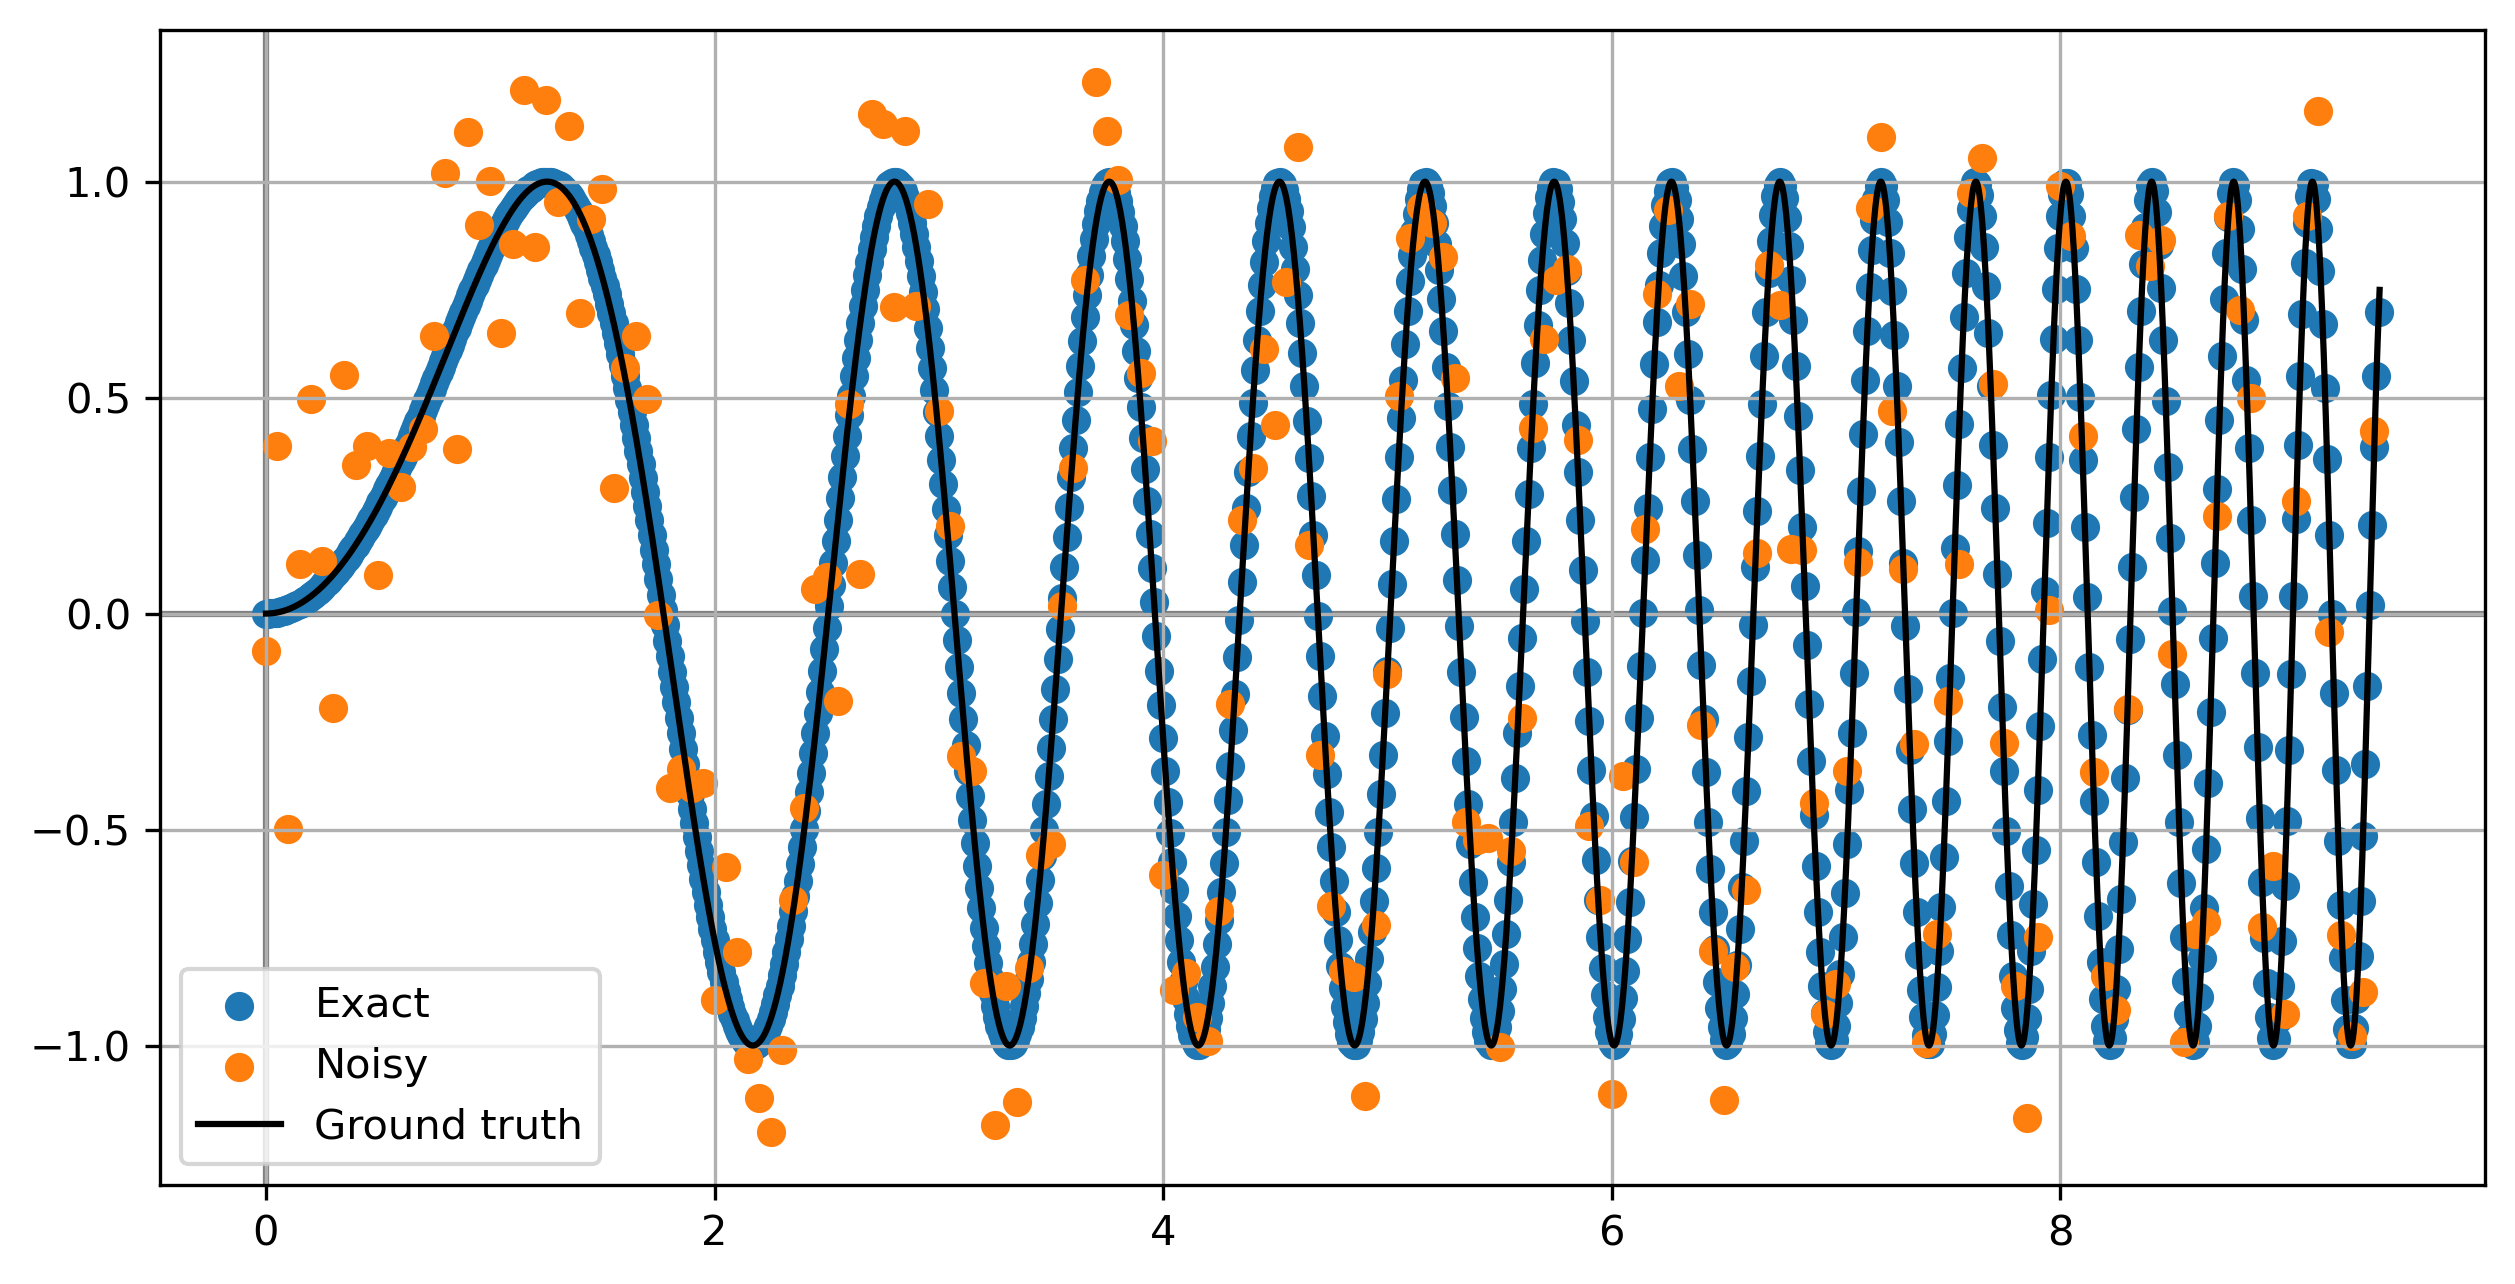

In [475]:
# Sample datapoints on which we are going to train
X, y   = generate_sine_data(step=0.01)
Xn, yn = generate_sine_data(noise=True)


# Get the true function
true_x = np.arange(0, SIN_EXERCISE_END_INTERVAL, 0.001)
true_y = f(true_x)

# Scatterplot of the training data
plt.scatter(X, y, label="Exact")
plt.scatter(Xn, yn, label="Noisy")
# Line of true function
plt.plot(true_x, true_y, color="black", label="Ground truth")
plt.grid()
plt.axhline(0, color="gray", zorder=0.01)
plt.axvline(0, color="gray", zorder=0.01)
plt.legend()
plt.show()

Turn the mean squared error loss function into a score function 

In [476]:
# score_func = make_scorer(mean_squared_error, greater_is_better=False)

## Without noise


Split into test and training data: 60% training data, 20% test data, 20% validation data

In [477]:
X_train, X_hold, y_train, y_hold = train_test_split(X, y, train_size=0.6)
X_valid, X_test, y_valid, y_test = train_test_split(X_hold, y_hold, train_size=.5)

Normalize the data

In [478]:
# mean, std = np.mean(X_train, axis = 0), np.std(X_train, axis = 0)
# X_train  = (X_train - mean)/std
# X_test   = (X_test  - mean)/std
# X_valid  = (X_valid - mean)/std

We define the network for training

In [483]:
net = FeedForwardNet(hidden_layer_sizes = (100,100), solver="sgd", n_iter_no_change = float('inf'))

In [484]:
net.train(X_train, y_train, X_valid, y_valid)

Plot the progress

In [498]:
net = regr
np.shape(net.loss_curve_)

(193,)

AttributeError: 'MLPRegressor' object has no attribute 'loss_curve_valid_'

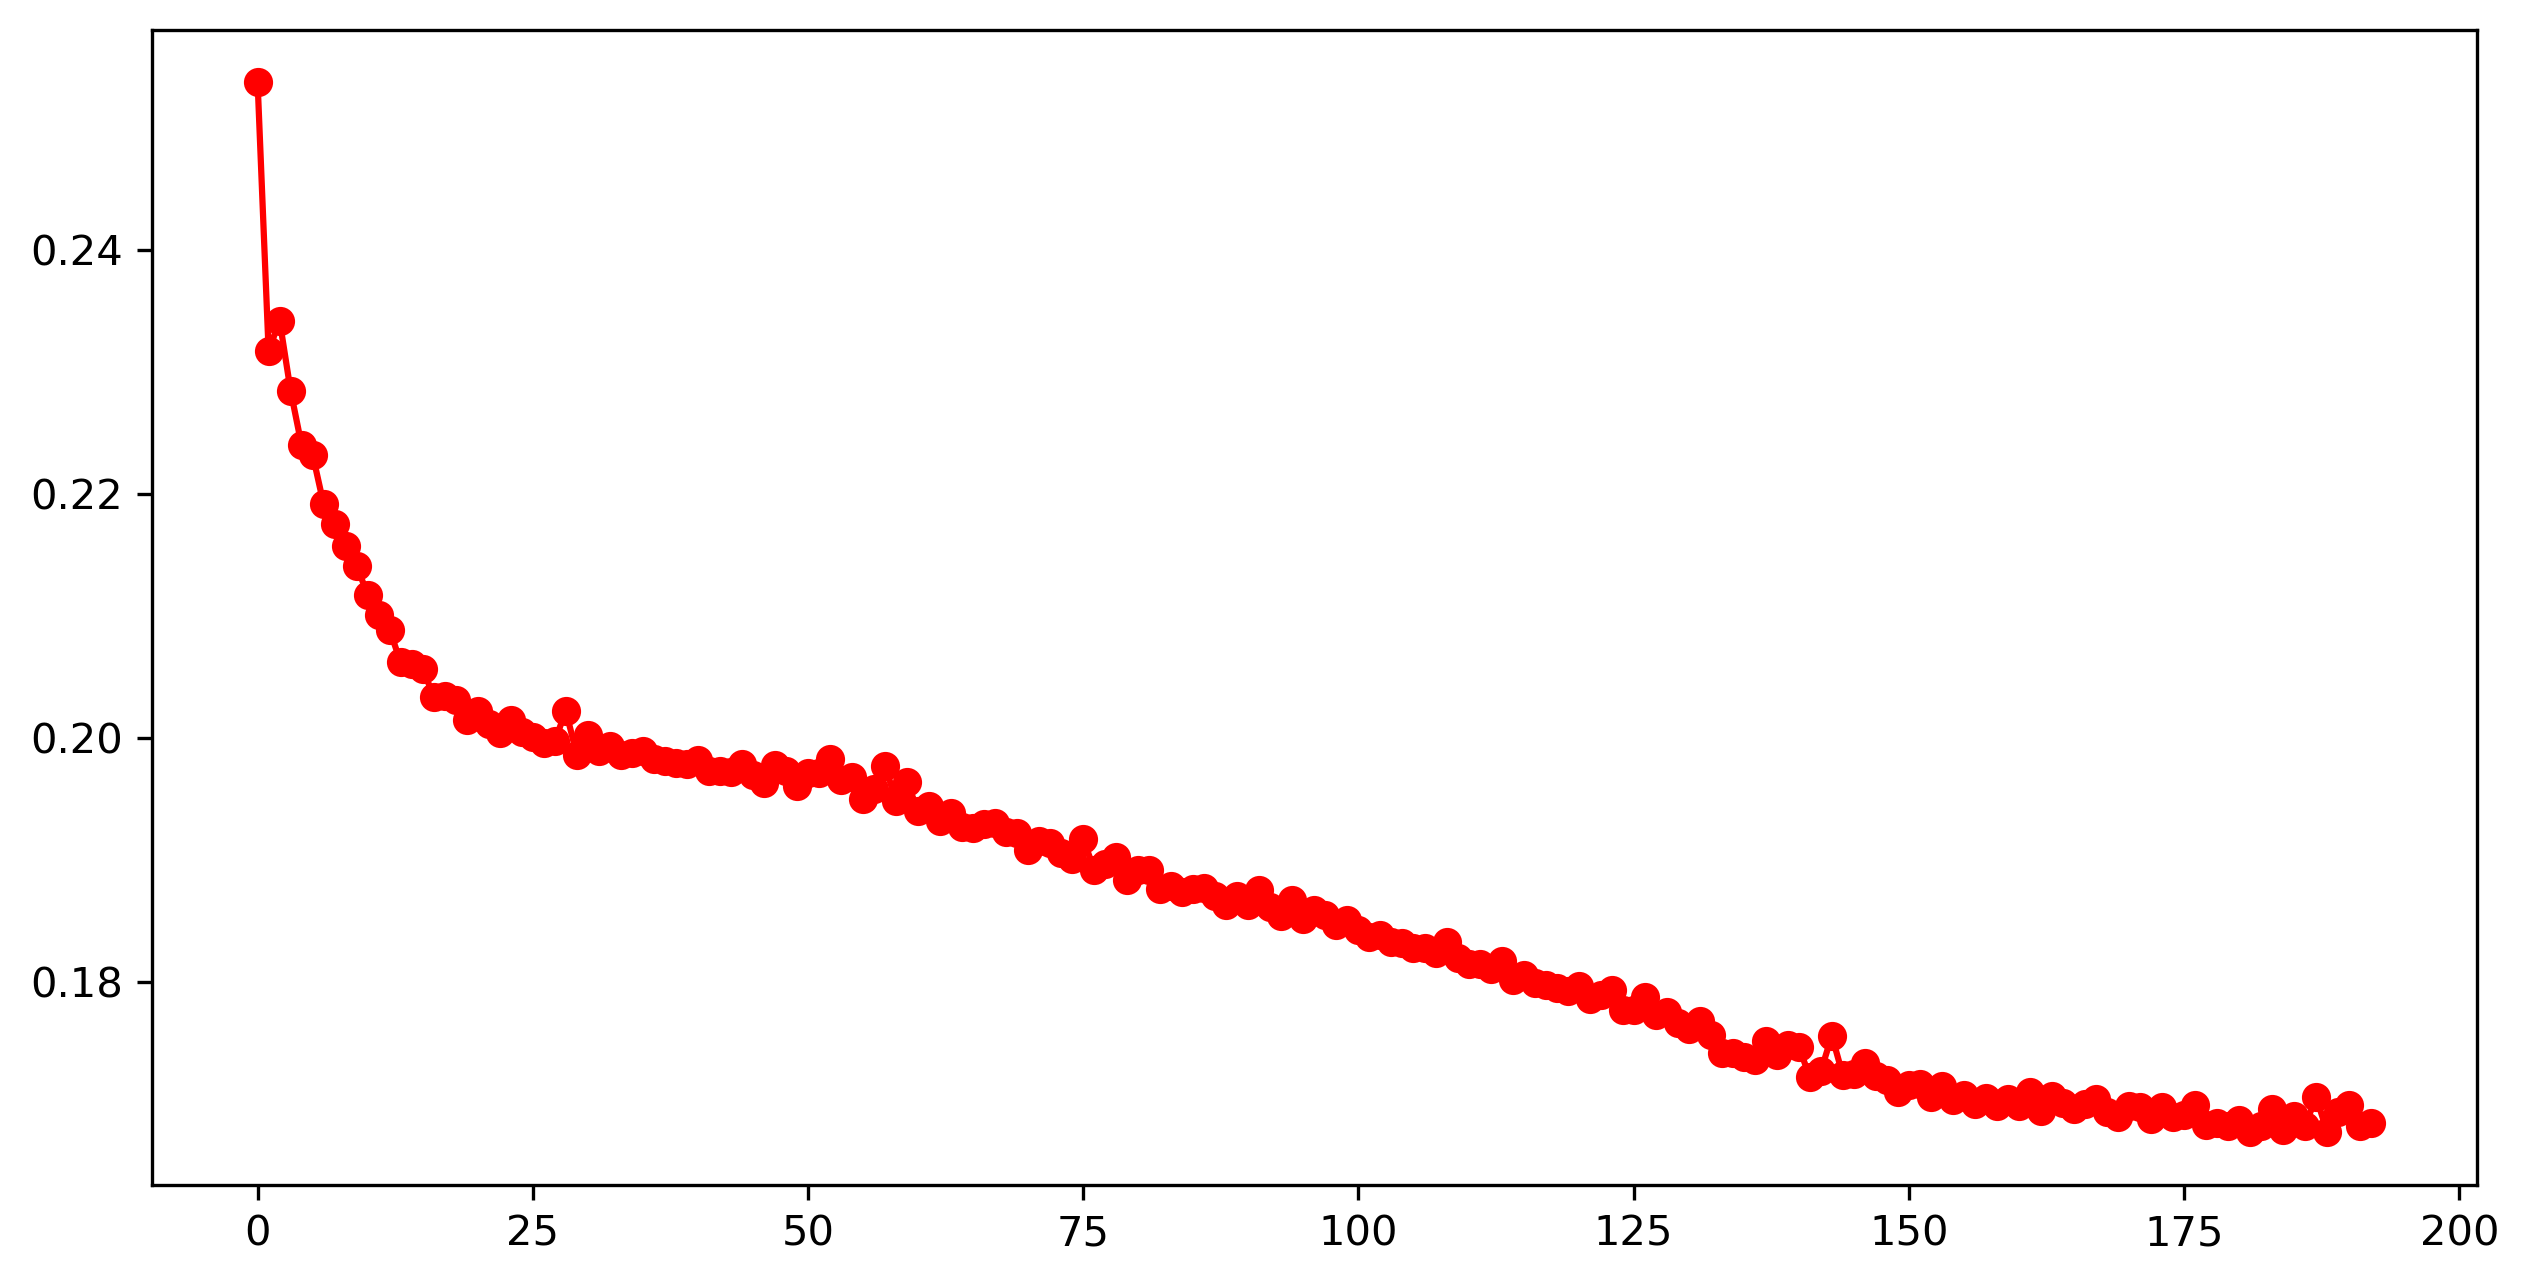

In [494]:
plt.plot(net.loss_curve_, '-o', color='red', label = "Training loss")
plt.plot(net.loss_curve_valid_, '-o', color='blue', label = "Validation loss")
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.axhline(net.best_valid_loss, color='black')
plt.axvline(net.best_iteration, color='black')
plt.legend()
plt.show()

Show the results

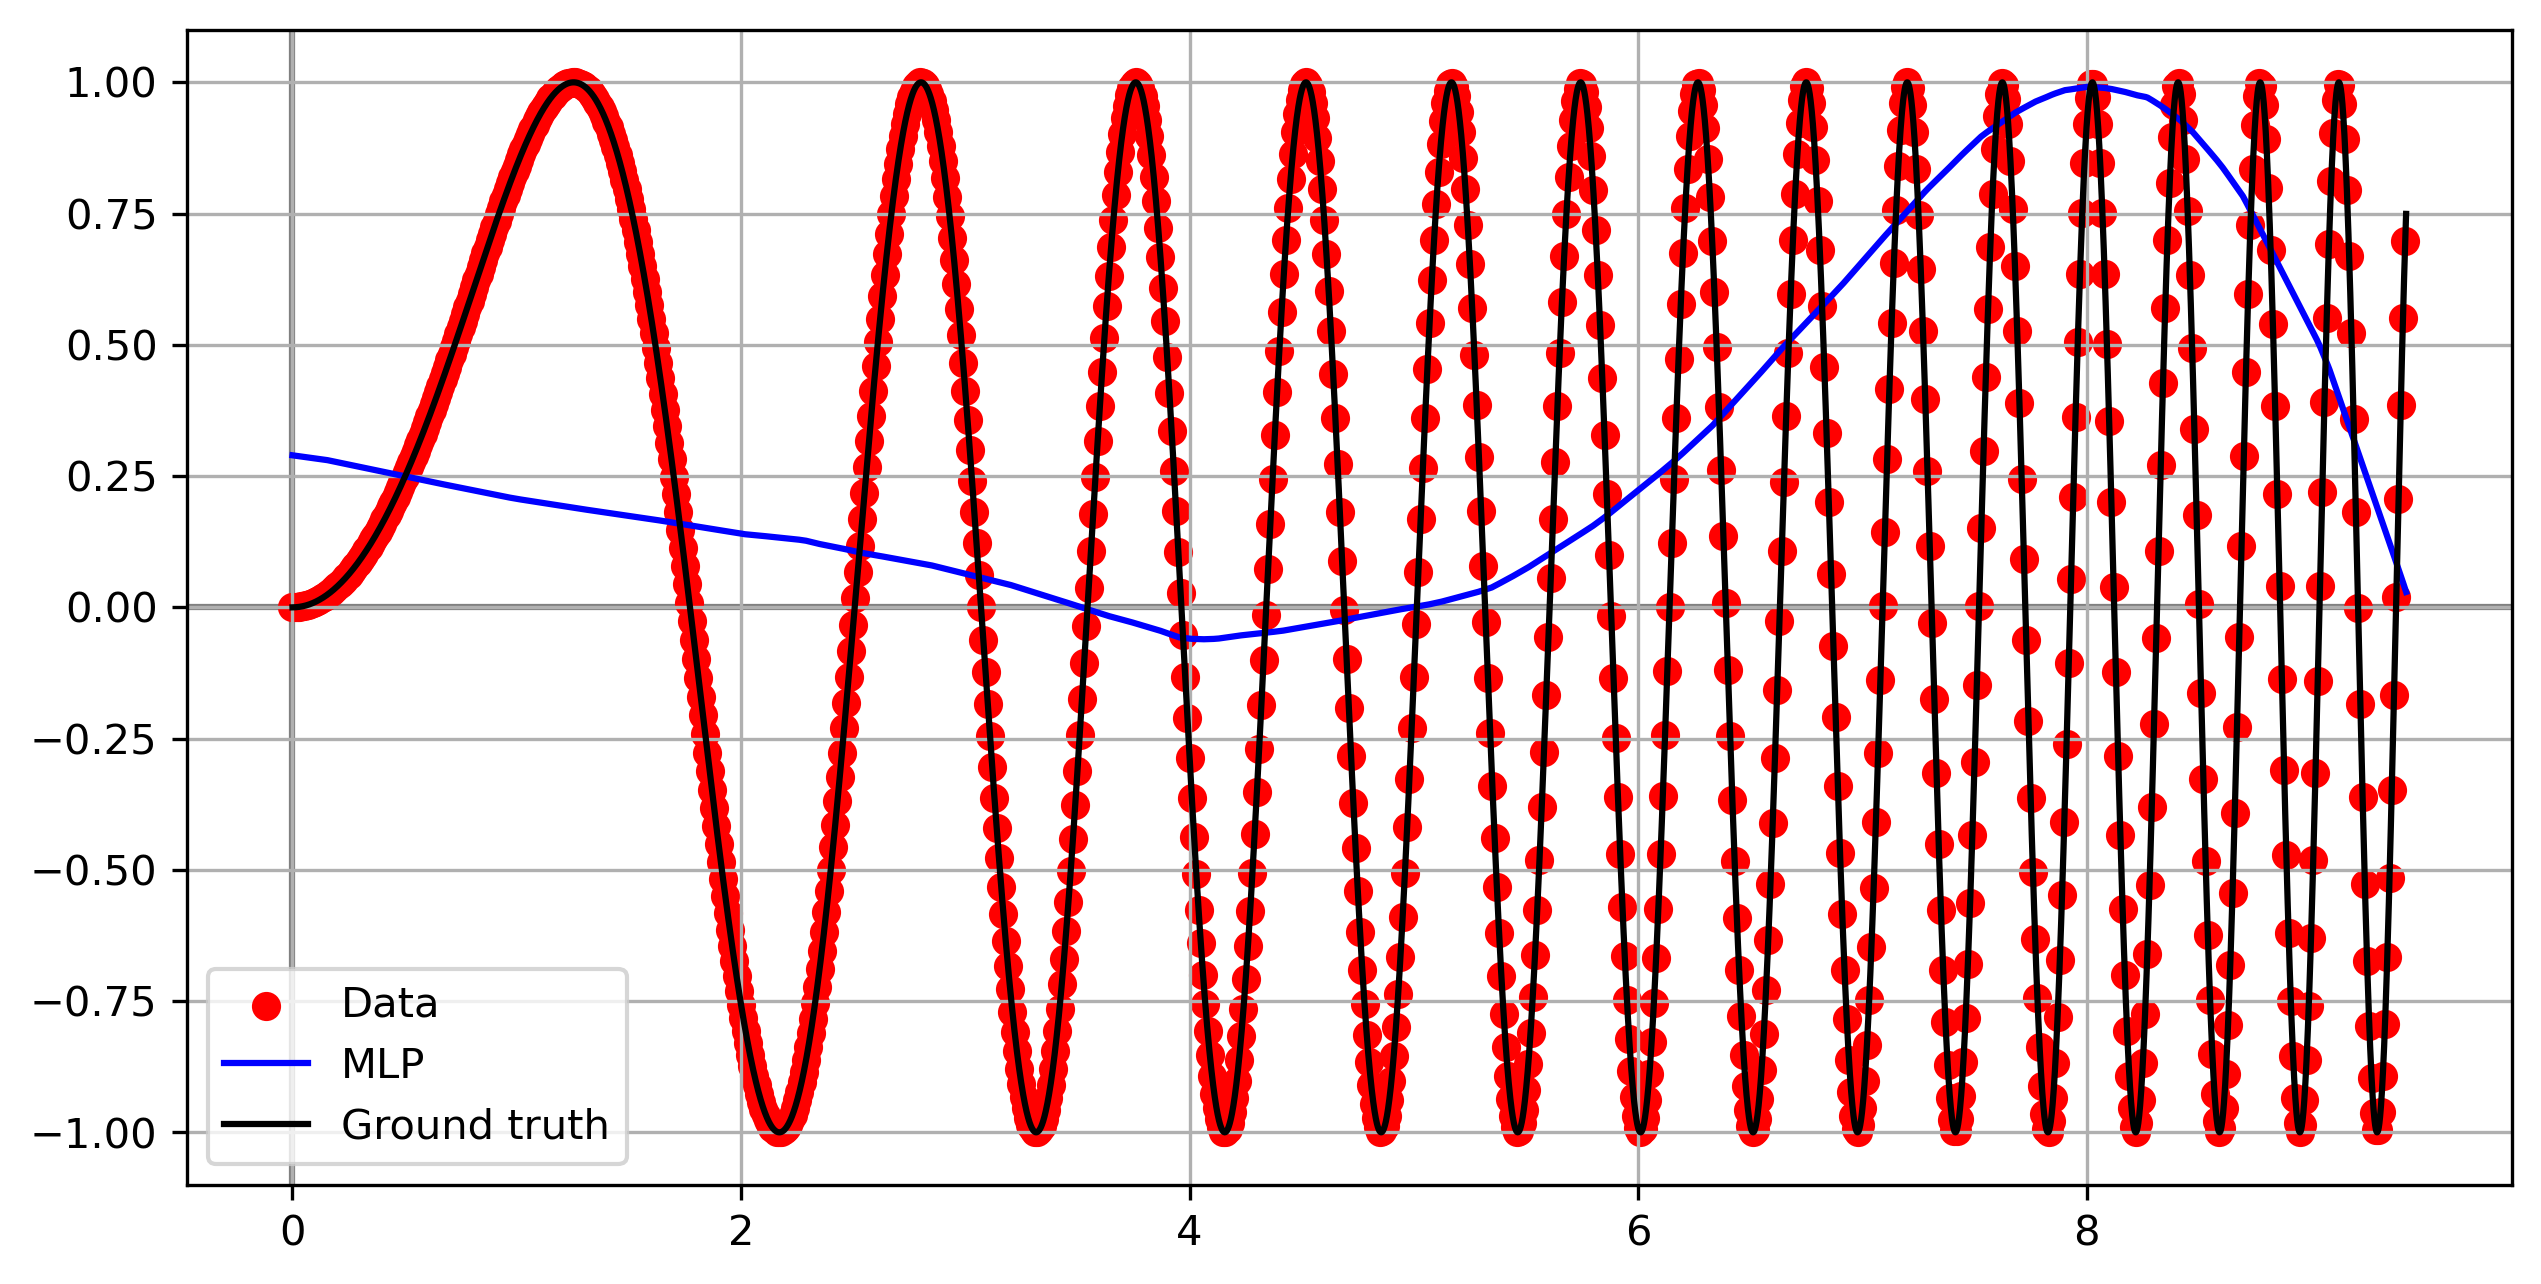

In [495]:
# Get the true function
true_x = np.arange(0, SIN_EXERCISE_END_INTERVAL, 0.001)
true_y = f(true_x)

# Scatterplot of the training data
plt.scatter(X, y, color='red', label="Data")
# For the prediction, also normalize the true_x data
plt.plot(true_x, net.predict(((true_x-mean)/std).reshape(-1,1)), color = 'blue', label="MLP")
# Line of true function
plt.plot(true_x, true_y, color="black", label="Ground truth")
plt.grid()
plt.axhline(0, color="gray", zorder=0.01)
plt.axvline(0, color="gray", zorder=0.01)
plt.legend()
plt.show()

### Grid search

In [243]:
param_dict = {
    "solver" : ["sgd", "adam"], 
    "hidden_layer_sizes" : [(10,), (20,)],
    "max_iter" : [1000],
    "n_iter_no_change": [100]}

In [244]:
def create_param_grid(param_dict):
    return list(ParameterGrid(param_dict)) 

In [245]:
def grid_search(param_dict, X_train, y_train, X_valid, y_valid, csv_filename = "grid_search", put_timestamp = True):
    
    # Create unique time identifier for the csv filename
    if put_timestamp:
        csv_filename += str(time.time())
    
    # Append right file format
    csv_filename += ".csv"
    
    # Initialize the CSV file: header takes the keys of param_grid as well
    # NOTE - these have to be attribute names of the FeedForwardNet class
    header = ["n_iter_", "time", "best_valid_loss"] + list(param_dict.keys())
    write_to_csv(csv_filename, header)
    
    # Convert param dict to param grid
    param_grid = create_param_grid(param_dict)
    
    # Iterate over the params, train, and save results
    for hyperparams in param_grid:
        # Create new net, set its hyperparams
        net = FeedForwardNet()
        net.set_params(**hyperparams)
        # Train the network
        net.train(X_train, y_train, X_valid, y_valid)
        # Write the results to a CSV file
        net.report(csv_filename, header)

In [246]:
grid_search(param_dict, X_train, y_train, X_valid, y_valid, put_timestamp=False)

Early stopping at 386
Early stopping at 390


In [247]:
df = pd.read_csv(os.path.join(data_dir, "grid_search.csv"))
df

,n_iter_,time,best_valid_loss,solver,hidden_layer_sizes,max_iter,n_iter_no_change
0,387,5.583117,0.235896,sgd,"(10,)",1000,100
1,1000,11.425005,0.205728,adam,"(10,)",1000,100
2,391,3.773128,0.232936,sgd,"(20,)",1000,100
3,1000,14.031237,0.209386,adam,"(20,)",1000,100


# Personal regression problem

Read in the .mat file

In [5]:
data = scipy.io.loadmat(os.path.join(master_dir, "Data/Data_Problem1_regression.mat"))
X1 = data['X1']
X1 = data['X2']
T1 = data['T1']
T2 = data['T2']
T3 = data['T3']
T4 = data['T4']
T5 = data['T5']

# Archive

In [ ]:
param_grid = {
    "solver" : ["adam", "sgd"], 
    "hidden_layer_sizes" : [(10,), (50,), (100,)]}

In [ ]:
param_search = GridSearchCV(FeedForwardNet(learning_rate_init = 1e-4, activation = 'tanh'), param_grid, scoring = score_func, n_jobs = 4)
param_search.fit(X_train, y_train)

GridSearchCV(estimator=FeedForwardNet(), n_jobs=4,
             param_grid={'hidden_layer_sizes': [(10,), (50,), (100,)],
                         'solver': ['adam', 'sgd']},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [ ]:
param_search.cv_results_

{'mean_fit_time': array([7.37041588, 3.7265759 , 2.79825864, 2.75132637, 1.92396078,
        1.93074703]),
 'std_fit_time': array([6.61862202, 1.82571197, 2.15875632, 0.95848055, 0.89476127,
        0.48593685]),
 'mean_score_time': array([0.00114174, 0.00111856, 0.00122862, 0.0010077 , 0.00056076,
        0.00070372]),
 'std_score_time': array([0.00105061, 0.00022589, 0.00125987, 0.00084116, 0.0005222 ,
        0.00039961]),
 'param_hidden_layer_sizes': masked_array(data=[(10,), (10,), (50,), (50,), (100,), (100,)],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_solver': masked_array(data=['adam', 'sgd', 'adam', 'sgd', 'adam', 'sgd'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'hidden_layer_sizes': (10,), 'solver': 'adam'},
  {'hidden_layer_sizes': (10,), 'solver': 'sgd'},
  {'hidden_layer_sizes': (50,), 'solver': 'adam'},
  {